Loading all dataframes

In [94]:
import pandas as pd
# UK Datasets
uk_ar1 = pd.read_csv("uk_ar1.csv").drop(columns = "Unnamed: 0").rename(columns={'Actual_infl_rate':'infl_rate','Date':'date','Forecast_infl_rate':'forecast_ar1'})
uk_ar1 = uk_ar1[['date','infl_rate','forecast_ar1']]
uk_arp = pd.read_csv("uk_arp.csv").drop(columns = "Unnamed: 0").rename(columns={'Actual_infl_rate':'infl_rate','Date':'date','Forecast_infl_rate':'forecast_arp'})
uk_arp = uk_arp[['date','infl_rate','forecast_arp']]
uk_adl = pd.read_csv("uk_adl.csv").drop(columns = "Unnamed: 0")
uk_ml_models = pd.read_csv("uk_ml_models_dates.csv").drop(columns = "Unnamed: 0").rename(columns={'actual':'infl_rate', 'lstm':'forecast_lstm','ridge':'forecast_ridge', 'pca':'forecast_pca'})
# US Datasets
us_ar1 = pd.read_csv("us_ar1.csv").drop(columns = "Unnamed: 0").rename(columns={'Actual_infl_rate':'infl_rate','Date':'date','Forecast_infl_rate':'forecast_ar1'})
us_ar1 = us_ar1[['date','infl_rate','forecast_ar1']]
us_arp = pd.read_csv("us_arp.csv").drop(columns = "Unnamed: 0").rename(columns={'Actual_infl_rate':'infl_rate','Date':'date','Forecast_infl_rate':'forecast_arp'})
us_arp = us_arp[['date','infl_rate','forecast_arp']]
us_adl = pd.read_csv("us_adl.csv").drop(columns = "Unnamed: 0")
us_ml_models = pd.read_csv("us_ml_models_dates.csv").drop(columns = "Unnamed: 0").rename(columns={'actual':'infl_rate', 'lstm':'forecast_lstm','ridge':'forecast_ridge', 'pca':'forecast_pca'})

In [95]:
# Keep only necessary columns
def adl_df_generator(adl_df):
    df = adl_df[['Date', 'Macro_Variable', 'Forecast_infl_rate', 'Actual_infl_rate']]
    pivot_df = df.pivot(index='Date', columns='Macro_Variable', values='Forecast_infl_rate')

    pivot_df = pivot_df.add_prefix('forecast_') # Rename forecast columns to reflect they’re forecasts
    pivot_df = pivot_df.reset_index()
    actuals = df[['Date', 'Actual_infl_rate']].drop_duplicates()

    # Merge actuals with pivoted forecasts
    final_df = pd.merge(actuals, pivot_df, on='Date').dropna()
    final_df = final_df.rename(columns={'Actual_infl_rate':'infl_rate', 'Date':'date'})
    return final_df

us_adl_df = adl_df_generator(us_adl)
uk_adl_df = adl_df_generator(uk_adl)

In [96]:
adl_ar1_us = pd.merge(us_adl_df, us_ar1, how = 'left',on=['date','infl_rate'])
trad_models_us = pd.merge(adl_ar1_us,us_arp,how='left',on=['date','infl_rate'])

adl_ar1_uk = pd.merge(uk_adl_df, uk_ar1, how = 'left',on=['date','infl_rate'])
trad_models_uk = pd.merge(adl_ar1_uk,uk_arp,how='left',on=['date','infl_rate'])

overall_combined_us = pd.merge(trad_models_us, us_ml_models, how = 'left', on = ['date']).drop(columns='infl_rate_y').rename(columns={'infl_rate_x':'infl_rate'})
overall_combined_uk = pd.merge(trad_models_uk, uk_ml_models, how = 'left', on = ['date']).drop(columns='infl_rate_y').rename(columns={'infl_rate_x':'infl_rate'})
# trad_models_uk

In [106]:
import numpy as np

def forecast_combi_fn(df, actual_col='infl_rate'):
    forecast_cols = [col for col in df.columns if 'forecast' in col]
    # Simple Average (Combination 1: Simple Average Forecast)
    df['simple_avg'] = df[forecast_cols].mean(axis=1)
    df['median_forecast'] = df[forecast_cols].median(axis=1)
    
    # Initialize a new column to store the final results
    df['err_weighted'] = np.nan

    # Loop through each row (Combination 2: Error-Weighted Forecast --> Bates-Granger combination)
    for idx, row in df.iterrows():
        if idx == 0:  # First row uses simple average
            df.at[idx, 'err_weighted'] = row[forecast_cols].mean()
        else: # Else construct error-weighted forecasts
            # Squared Error for each individual model
            sq_errors = ((df.loc[(idx-1), forecast_cols] - df.loc[(idx-1), actual_col]).abs())**2

            # Compute inverse weights for each individual model
            inv_weights = 1 / (sq_errors + 1e-6)  # Add small value to avoid division by zero

            # Normalize weights to sum to 1
            norm_weights = inv_weights / inv_weights.sum()

            # Compute the error-weighted forecast for each row
            weighted_forecast = (row[forecast_cols] * norm_weights).sum()

            df.at[idx, 'err_weighted'] = weighted_forecast

    return df
    
combined_us = forecast_combi_fn(overall_combined_us)
combined_uk = forecast_combi_fn(overall_combined_uk)
combined_us.to_csv('us_all_forecasts.csv')
combined_uk.to_csv('uk_all_forecasts.csv')

In [105]:
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# RMSE for Ridge
rmse_bg_us_monthly = calculate_rmse(combined_us['infl_rate'], combined_us['err_weighted'])
rmse_bg_us_monthly

rmse_bg_uk_monthly = calculate_rmse(combined_uk['infl_rate'], combined_uk['simple_avg'])
rmse_bg_uk_monthly

0.0027413300904953826

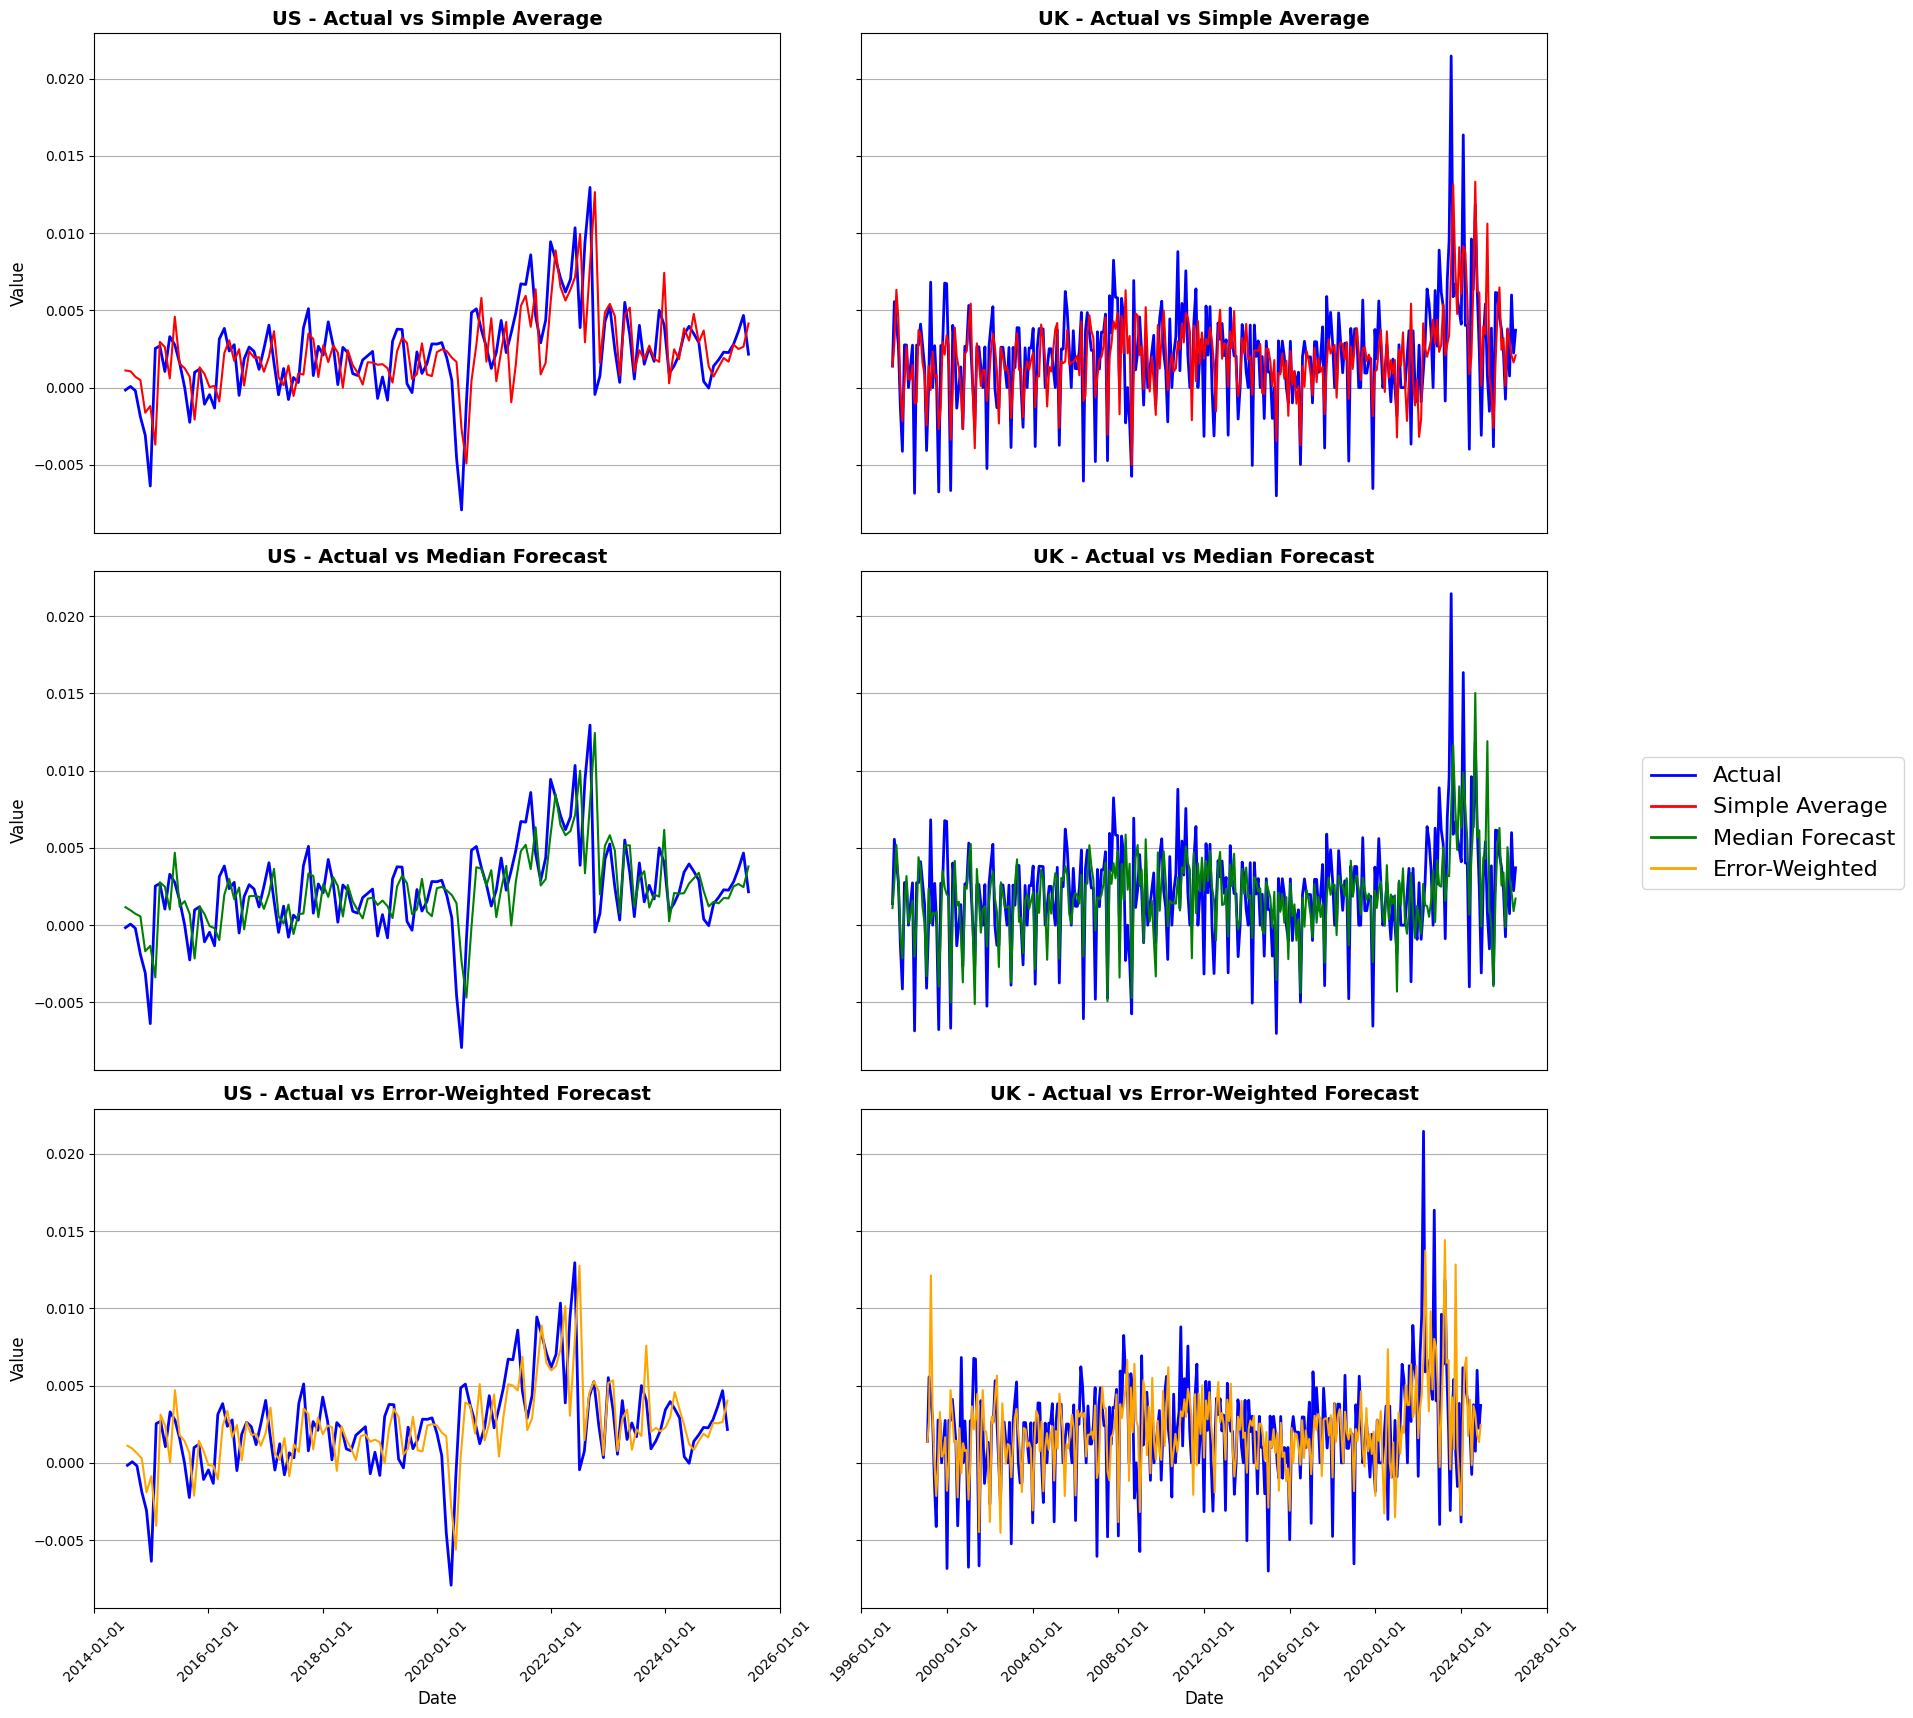

In [112]:

import matplotlib.pyplot as plt
def plot_us_uk_comparison(us_results, uk_results):
    us_results = us_results[us_results['date']>='01-01-2014']
    uk_results = uk_results[uk_results['date']>='06-01-2014']
    us_results['date']=pd.to_datetime(us_results['date'])
    uk_results['date']=pd.to_datetime(uk_results['date'])
    # return(uk_results)
    # Create a 3x2 subplot grid (3 rows, 2 columns)
    fig, axs = plt.subplots(3, 2, figsize=(16, 18), sharey='all')

    # Plot US results in the first column
    axs[0, 0].plot(us_results["date"], us_results["infl_rate"], label="Actual", color='blue', linewidth=2)
    axs[0, 0].plot(us_results["date"], us_results["simple_avg"], label="Simple Average", color='red')
    axs[0, 0].set_ylabel("Value", fontsize=12)
    axs[0, 0].set_title("US - Actual vs Simple Average", fontsize=14, fontweight = 'bold')
    axs[0, 0].grid(True)  # Add grid
    axs[0, 0].set_xticks([])  # Remove x-ticks
    # axs[0, 0].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))
    
    axs[1, 0].plot(us_results["date"], us_results["infl_rate"], label="Actual", color='blue', linewidth=2)
    axs[1, 0].plot(us_results["date"], us_results["median_forecast"], label="Median Forecast", color='green')
    axs[1, 0].set_ylabel("Value", fontsize=12)
    axs[1, 0].set_title("US - Actual vs Median Forecast", fontsize=14, fontweight = 'bold')
    axs[1, 0].grid(True)  # Add grid
    axs[1, 0].set_xticks([])  # Remove x-ticks
    # axs[1, 0].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    axs[2, 0].plot(us_results["date"], us_results["infl_rate"], label="Actual", color='blue', linewidth=2)
    axs[2, 0].plot(us_results["date"], us_results["err_weighted"], label="Error-Weighted", color='orange')
    axs[2, 0].set_xlabel("Date", fontsize=12)
    axs[2, 0].set_ylabel("Value", fontsize=12)
    axs[2, 0].set_title("US - Actual vs Error-Weighted Forecast", fontsize=14, fontweight = 'bold')
    axs[2, 0].grid(True, axis='y')  # Add grid
    # axs[2, 0].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    # Plot UK results in the second column
    axs[0, 1].plot(uk_results["date"], uk_results["infl_rate"], label="Actual", color='blue', linewidth=2)
    axs[0, 1].plot(uk_results["date"], uk_results["simple_avg"], label="Simple Average", color='red')
    # axs[0, 1].set_ylabel("Value", fontsize=12)
    axs[0, 1].set_title("UK - Actual vs Simple Average", fontsize=14, fontweight = 'bold')
    axs[0, 1].grid(True)  # Add grid
    axs[0, 1].set_xticks([])  # Remove x-ticks
    # axs[0, 1].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    axs[1, 1].plot(uk_results["date"], uk_results["infl_rate"], label="Actual", color='blue', linewidth=2)
    axs[1, 1].plot(uk_results["date"], uk_results["median_forecast"], label="Median Forecast", color='green')
    # axs[1, 1].set_ylabel("Value", fontsize=12)
    axs[1, 1].set_title("UK - Actual vs Median Forecast", fontsize=14, fontweight = 'bold')
    axs[1, 1].grid(True)  # Add grid
    axs[1, 1].set_xticks([])  # Remove x-ticks
    # axs[1, 1].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))
    
    axs[2, 1].plot(uk_results["date"], uk_results["infl_rate"], label="Actual", color='blue', linewidth=2)
    axs[2, 1].plot(uk_results["date"], uk_results["err_weighted"], label="Error-Weighted", color='orange')
    axs[2, 1].set_xlabel("Date", fontsize=12)
    # axs[2, 1].set_ylabel("Value", fontsize=12)
    axs[2, 1].set_title("UK - Actual vs Error-Weighted Forecast", fontsize=14, fontweight = 'bold')
    axs[2, 1].grid(True, axis='y')  # Add grid
    # axs[2, 1].set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2025-06-01"))

    # Define a single custom legend for all subplots
    handles = [
        plt.Line2D([0], [0], color='blue', lw=2, label='Actual'),
        plt.Line2D([0], [0], color='red', lw=2, label='Simple Average'),
        plt.Line2D([0], [0], color='green', lw=2, label='Median Forecast'),
        plt.Line2D([0], [0], color='orange', lw=2, label='Error-Weighted')
    ]
    labels = ['Actual', 'Simple Average', 'Median Forecast', 'Error-Weighted']

    # Add a common legend with the custom handles
    fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1.2, 0.5), fontsize=16)

    # Rotate x-axis labels for all subplots
    for ax in axs.flat:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust title and layout

    # Show plot
    plt.show()

plot_us_uk_comparison(combined_us, combined_uk)